In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import local_binary_pattern
import time

In [3]:
# Usamos LBP Uniforme porque es invariante a la rotación y reduce el ruido
# P = Puntos vecinos, R = Radio
P = 24  # Más puntos que el estándar (8) para capturar más detalle facial
R = 3   # Radio más amplio
METHOD = 'uniform'

class LBP_Descriptor:
    def __init__(self, P=8, R=1):
        self.P = P
        self.R = R
    
    def describe(self, image):
        # 1. Calcular la imagen LBP
        lbp_image = local_binary_pattern(image, self.P, self.R, method=METHOD)
        
        # 2. Convertir la imagen LBP en un Vector (Histograma)
        # Importante: Dividimos la cara en regiones (grid) para no perder
        # la información espacial (dónde están los ojos, la boca, etc.)
        # Si hacemos un histograma global, la IA no sabría dónde están los ojos.
        
        # Grid de 7x7 bloques
        (h, w) = image.shape
        h_step, w_step = h // 7, w // 7
        
        hist_concatenated = []
        
        for i in range(0, h, h_step):
            for j in range(0, w, w_step):
                # Extraer bloque
                cell = lbp_image[i:i+h_step, j:j+w_step]
                
                # Calcular histograma del bloque
                # n_bins = P + 2 para el método 'uniform'
                n_bins = int(lbp_image.max() + 1)
                hist, _ = np.histogram(cell.ravel(), bins=n_bins, range=(0, n_bins))
                
                # Normalizar el histograma
                hist = hist.astype("float")
                hist /= (hist.sum() + 1e-7)
                
                hist_concatenated.extend(hist)

        return np.array(hist_concatenated)


In [9]:
# --- 2. CARGAR DATOS 
print("Descargando/Cargando dataset LFW (Caras)...")
lfw_people = fetch_lfw_people(min_faces_per_person=80, resize=0.4)
X_images = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

print(f"Imágenes cargadas: {X_images.shape[0]}")
print(f"Dimensiones: {X_images.shape[1]}x{X_images.shape[2]}")

Descargando/Cargando dataset LFW (Caras)...
Imágenes cargadas: 1140
Dimensiones: 50x37


In [10]:
# --- 3. EXTRACCIÓN DE CARACTERÍSTICAS (El corazón del código) ---
print("Iniciando extracción de características LBP...")
start_time = time.time()

desc = LBP_Descriptor(P=P, R=R)
data = []

for img in X_images:
    # Obtenemos el histograma concatenado de la imagen
    hist = desc.describe(img)
    data.append(hist)

X_lbp = np.array(data)

print(f"Tiempo de extracción: {time.time() - start_time:.2f} segundos")
print(f"Dimensión del vector de características: {X_lbp.shape[1]}")

Iniciando extracción de características LBP...
Tiempo de extracción: 2.95 segundos
Dimensión del vector de características: 1664


In [11]:
# --- 4. ENTRENAMIENTO (SVM) ---
print("Entrenando SVM Lineal...")
X_train, X_test, y_train, y_test = train_test_split(X_lbp, y, test_size=0.25, random_state=42)

model = LinearSVC(random_state=42, dual="auto", max_iter=10000)
model.fit(X_train, y_train)


Entrenando SVM Lineal...


,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo rand

In [12]:
# --- 5. EVALUACIÓN ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n---> Precisión del modelo (Accuracy): {acc*100:.2f}% <---")


---> Precisión del modelo (Accuracy): 90.53% <---


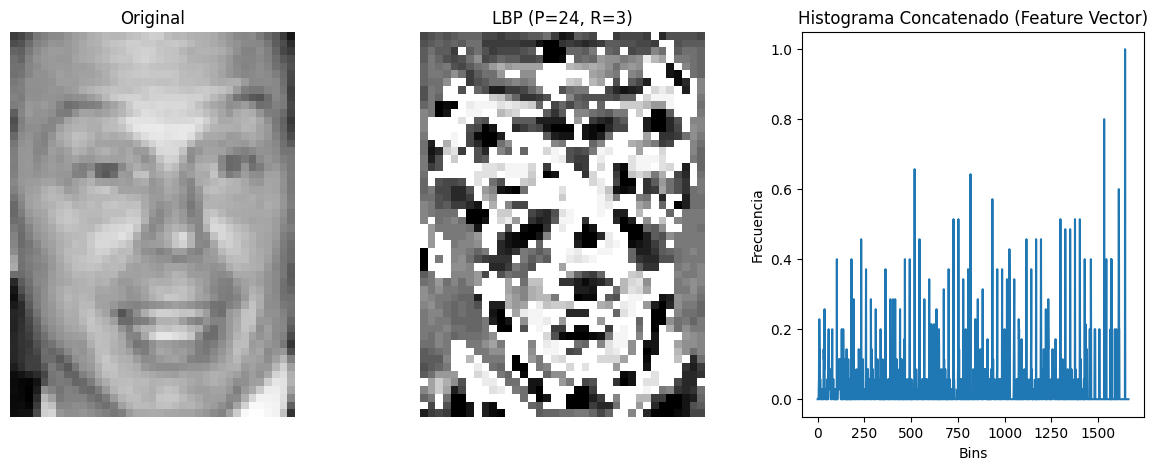

In [14]:
# --- 6. VISUALIZACIÓN ---
# Vamos a ver qué "ve" el algoritmo: Imagen Real vs Imagen LBP vs Histograma
idx = np.random.randint(0, len(X_test))
sample_img = lfw_people.images[idx] # Imagen original (necesitamos buscarla en el set completo o guardar índices)
# Recalculamos LBP solo para visualizar
lbp_vis = local_binary_pattern(sample_img, P, R, method=METHOD)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 1. Imagen Original
ax1.imshow(sample_img, cmap='gray')
ax1.set_title("Original")
ax1.axis('off')

# 2. Imagen LBP (La textura)
ax2.imshow(lbp_vis, cmap='gray')
ax2.set_title(f"LBP (P={P}, R={R})")
ax2.axis('off')

# 3. Vector de Características (Lo que entra al SVM)
# (Mostramos solo una parte del vector larguísimo para que se entienda)
feature_vector = desc.describe(sample_img)
ax3.plot(feature_vector)
ax3.set_title("Histograma Concatenado (Feature Vector)")
ax3.set_xlabel("Bins")
ax3.set_ylabel("Frecuencia")

plt.show()